In [70]:
import yfinance as yf
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
import plotly.graph_objects as go
from plotly.graph_objs.scatter.marker import Line
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import math 
import warnings
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

warnings.filterwarnings('ignore')

### Downloading and Preparing S&P 500 Data for Analysis

In [71]:
# Downloading and Preparing S&P 500 Data for Analysis

# Step 1: Download historical data
# Fetch daily historical price data for the SPY ETF (S&P 500 proxy) from Yahoo Finance
prices = yf.download('SPY', start="1997-01-01", end="2024-07-31")

# Step 2: Remove duplicate columns
# Eliminate any duplicated columns that may arise during data fetching
prices = prices.loc[:, ~prices.columns.duplicated()]

# Step 3: Select the closing prices
# Extract only the 'Close' column and create a new DataFrame for further analysis
prices = pd.DataFrame(prices['Close'])

# Step 4: Rename the 'Close' column
# Rename the column to 'SP500' for better clarity and reference
prices.rename(columns={'Close': 'SP500'}, inplace=True)

# Step 5: Assign a column group name
# Add a label to the column for tracking the trading instrument
trading_instrument = 'SPY'
prices.columns.name = trading_instrument

# Step 6: Plot the closing prices
# Use Plotly to visualize the SPY's closing prices over time
px.line(prices['SPY'], title="SPY Closing Prices (1997-2024)")


[*********************100%***********************]  1 of 1 completed


### Function to Prepare Data for Model Input

In [72]:
def prepare_data_for_model_input(prices, ma):
    """
    Prepare data for input into financial models by calculating moving averages and log returns.

    Parameters:
    ----------
    prices (DataFrame): DataFrame containing the closing prices of the instrument.
    ma (int): Length of the moving average window.

    Returns:
    -------
    prices (DataFrame): Enhanced DataFrame with moving average and log return columns.
    prices_array (ndarray): Numpy array of log returns suitable for model input.
    """
    # Retrieve the name of the instrument (assigned as column group name)
    instrument = prices.columns.name

    # Calculate the moving average of the prices over the specified window
    prices[f'{instrument}_ma'] = prices.rolling(ma).mean()

    # Compute log returns based on the moving average
    prices[f'{instrument}_log_return'] = np.log(
        prices[f'{instrument}_ma'] / prices[f'{instrument}_ma'].shift(1)
    ).dropna()

    # Drop rows with NaN values after calculating the moving average and log return
    prices.dropna(inplace=True)

    # Convert log returns into a 2D numpy array for model input
    prices_array = np.array([[q] for q in prices[f'{instrument}_log_return'].values])

    return prices, prices_array

prices, prices_array = prepare_data_for_model_input(prices, 7)

### Function to Perform Feed-Forward Training for Regime Detection Models

In [73]:
def feed_forward_training(model, params, prices, split_index, retrain_step):
    """
    Perform feed-forward training and prediction using a specified regime detection model.

    Parameters:
    ----------
    model (method): Either a Gaussian Mixture Model (GMM) or Hidden Markov Model (HMM) class.
    params (dict): Dictionary containing parameters for the selected model.
    prices (DataFrame): DataFrame of close prices or model features.
    split_index (str): Index to split the initial training dataset and out-of-sample testing set.
    retrain_step (int): Number of observations after which the model is retrained.

    Returns:
    -------
    states_pred (ndarray): Array of predicted hidden states for the out-of-sample test set.
    """
    # Step 1: Train/Test Split
    # Split the dataset into an initial training set and an out-of-sample testing set
    init_train_data = prices[:split_index]
    test_data = prices[split_index:]

    # Step 2: Initial Model Training
    # Train the specified model using the initial training data and parameters
    rd_model = model(init_train_data, params)

    # Step 3: Predict States in a Feed-Forward Manner
    states_pred = []  # Store predicted hidden states
    for i in range(math.ceil(len(test_data))):
        # Increment the split index for feed-forward prediction
        split_index += 1

        # Predict hidden states up to the current observation
        preds = rd_model.predict(prices[:split_index]).tolist()
        states_pred.append(preds[-1])  # Append the state of the most recent observation

        # Step 4: Retrain the Model
        # Retrain the model periodically based on the retrain_step interval
        if i % retrain_step == 0:
            rd_model = model(prices[:split_index], params)

    return states_pred


### Class for Regime Detection Using Various Models

In [74]:
class RegimeDetection:
    """
    A class for detecting market regimes using various models, including Hidden Markov Models (HMM),
    Gaussian Mixture Models (GMM), and clustering algorithms.

    Methods:
    -------
    get_regimes_hmm(input_data, params):
        Fits a Gaussian Hidden Markov Model (HMM) to the input data.
        
    get_regimes_clustering(params):
        Initializes an Agglomerative Clustering model with the specified parameters.
        
    get_regimes_gmm(input_data, params):
        Fits a Gaussian Mixture Model (GMM) to the input data.
        
    initialise_model(model, params):
        Configures the given model with specified parameters.
    """

    def get_regimes_hmm(self, input_data, params):
        """
        Train a Gaussian Hidden Markov Model (HMM) on the input data.

        Parameters:
        ----------
        input_data (ndarray or DataFrame): The data used to train the HMM.
        params (dict): Dictionary of model parameters to configure the HMM.

        Returns:
        -------
        hmm_model (GaussianHMM): Trained HMM model.
        """
        hmm_model = self.initialise_model(GaussianHMM(), params).fit(input_data)
        return hmm_model

    def get_regimes_clustering(self, params):
        """
        Initialize an Agglomerative Clustering model with the specified parameters.

        Parameters:
        ----------
        params (dict): Dictionary of model parameters for clustering.

        Returns:
        -------
        clustering (AgglomerativeClustering): Configured clustering model.
        """
        clustering = self.initialise_model(AgglomerativeClustering(), params)
        return clustering

    def get_regimes_gmm(self, input_data, params):
        """
        Train a Gaussian Mixture Model (GMM) on the input data.

        Parameters:
        ----------
        input_data (ndarray or DataFrame): The data used to train the GMM.
        params (dict): Dictionary of model parameters to configure the GMM.

        Returns:
        -------
        gmm (GaussianMixture): Trained GMM model.
        """
        gmm = self.initialise_model(GaussianMixture(), params).fit(input_data)
        return gmm

    def initialise_model(self, model, params):
        """
        Configure the given model with specified parameters.

        Parameters:
        ----------
        model (object): The model instance to be configured (e.g., HMM, GMM, or clustering).
        params (dict): Dictionary of parameter names and their values.

        Returns:
        -------
        model (object): Model instance with updated parameters.
        """
        for parameter, value in params.items():
            setattr(model, parameter, value)  # Dynamically set model attributes
        return model


### Function to Plot Hidden States with Prices

In [75]:
def plot_hidden_states(hidden_states, prices_df):
    """
    Visualize hidden states over time alongside closing prices.

    Parameters:
    ----------
    hidden_states (ndarray): Array of predicted hidden states from a model.
    prices_df (DataFrame): DataFrame containing the close prices and their associated dates.

    Output:
    -------
    A Plotly graph displaying the hidden states and prices with color-coded markers.
    """
    
    # Define colors for the hidden states
    colors = ['red', 'green']  # Modify or expand based on the number of states
    n_components = len(np.unique(hidden_states))  # Number of unique hidden states

    # Initialize the Plotly figure
    fig = go.Figure()

    # Loop through each hidden state to plot corresponding observations
    for i in range(n_components):
        mask = hidden_states == i  # Create a mask for the current hidden state
        print('Number of observations for State ', i, ":", len(prices_df.index[mask]))
        
        # Add a scatter trace for the current hidden state
        fig.add_trace(go.Scatter(
            x=prices_df.index[mask],  # Dates
            y=prices_df[f"{prices_df.columns.name}"][mask],  # Prices
            mode='markers',
            name='Hidden State ' + str(i),  # Legend label
            marker=dict(size=4, color=colors[i])  # Marker size and color
        ))

    # Update figure layout with dimensions and legend placement
    fig.update_layout(
        height=400,
        width=900,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        ),
        margin=dict(l=20, r=20, t=20, b=20)  # Reduce margins for compact layout
    ).show()


### Regime Detection Model Initialization and Parameter Configuration

In [76]:
# Initialize Regime Detection Class
regime_detection = RegimeDetection()

# Step 1: Define the Hidden Markov Model (HMM)
# Use the RegimeDetection class to create a Hidden Markov Model (HMM) with specified parameters
model_hmm = regime_detection.get_regimes_hmm
params_hmm = {
    'n_components': 2,  # Number of hidden states
    'covariance_type': 'full',  # Full covariance for state distribution
    'random_state': 100  # Ensure reproducibility
}

# Step 2: Define the Gaussian Mixture Model (GMM)
# Use the RegimeDetection class to create a Gaussian Mixture Model (GMM) with specified parameters
model_gmm = regime_detection.get_regimes_gmm
params_gmm = {
    'n_components': 2,  # Number of clusters
    'covariance_type': 'full',  # Full covariance for cluster distribution
    'max_iter': 100000,  # Maximum number of iterations
    'n_init': 30,  # Number of initializations to improve solution quality
    'init_params': 'kmeans',  # Initialization method
    'random_state': 100  # Ensure reproducibility
}

# Step 3: Define the Split Index
# Identify the index to split the dataset into training and testing data
split_index = np.where(prices.index > '2006-01-01')[0][0]  # First index after 2006-01-01


### Training HMM and Visualizing Predicted Hidden States

In [77]:
# Step 1: Train the HMM and Predict Hidden States
# Use feed-forward training with the defined Hidden Markov Model (HMM)
states_pred_hmm = feed_forward_training(model_hmm, params, prices_array, split_index, 20)

# Step 2: Visualize Predicted Hidden States
# Use the plot_hidden_states function to visualize the HMM-predicted hidden states
plot_hidden_states(np.array(states_pred_hmm), prices[[f'{trading_instrument}']][split_index:])


Number of observations for State  0 : 368
Number of observations for State  1 : 4306


### Incorporating Predicted States into Prices DataFrame and Filtering Results

In [78]:
# Incorporating Predicted States into Prices DataFrame and Filtering Results

# Step 1: Create an empty array for predicted states
# Initialize an array of the same length as 'prices' filled with NaN values
states_column = np.full(len(prices), np.nan)

# Step 2: Assign predicted states
# Populate the array with predicted states starting from the split index
states_column[split_index:] = np.array(states_pred_hmm)

# Step 3: Add predicted states to the DataFrame
# Add the predicted states as a new column in the 'prices' DataFrame
prices['Predicted_States'] = states_column

# Step 4: Filter out rows with NaN values
# Drop rows where the 'Predicted_States' column has NaN values
filtered_prices = prices.dropna(subset=['Predicted_States'])

# Step 5: Select relevant columns
# Keep only the 'Predicted_States' column in the filtered DataFrame
filtered_prices = filtered_prices[['Predicted_States']]

# Optional Step: Further filtering
# Uncomment the line below to filter rows based on a specific date range
# filtered_prices = filtered_prices[filtered_prices.index >= '2010-01-31']

# Optional Step: Reset the index
# Uncomment the line below to reset the index for cleaner indexing
# filtered_prices = filtered_prices.reset_index(drop=True)




### Loading and Preprocessing the Hackathon Sample Dataset

In [79]:
# Loading and Preprocessing the Hackathon Sample Dataset

def push_to_last_day(date):
    """
    Adjust a given date to the last day of its respective month.

    Parameters:
    ----------
    date (datetime): The input date to adjust.

    Returns:
    -------
    datetime: The adjusted date, which is the last day of the month.
    """
    # Check if the date is already the last day of the month
    if date == date + pd.offsets.MonthEnd(0):  # No adjustment needed
        return date
    else:  # Adjust to the last day of the month
        return date + pd.offsets.MonthEnd(0)

# Step 1: Load the dataset
# Read the CSV file containing the "hackathon_sample" data
huge_df = pd.read_csv(r"D:\05.Laboral\08.Git and github\02.All Weather Fundamental Surprise Enhanced Momentum Strategy\hackathon_sample.csv")

# Step 2: Convert date column to datetime
# Parse the 'date' column as datetime using the specified format
huge_df['date'] = pd.to_datetime(huge_df['date'], format='%Y%m%d')

# Step 3: Adjust dates to the last day of the month
# Apply the 'push_to_last_day' function to align all dates to the month's end
huge_df['date'] = huge_df['date'].apply(push_to_last_day)


### Preparing Individual Stock Excess Returns and Momentum Factors DataFrames


In [80]:
# Step 1: Extract the individual stock excess returns
# Create a DataFrame containing excess returns and risk-free rate data
er_df = huge_df[['date', 'permno', 'rf', 'stock_exret']]

# Step 2: Extract the momentum factors
# Create a DataFrame containing momentum-related factors such as past returns and net income to book equity
factor_df = huge_df[['date', 'permno', 'ret_12_1', 'ni_be']]

# Step 3: Filter momentum factors by date
# Keep only rows where the 'date' column is on or after 2010-01-31
factor_df = factor_df[factor_df['date'] >= '2010-01-31']

# Step 4: Reset the index
# Optionally reset the index for cleaner indexing in the filtered DataFrame
factor_df = factor_df.reset_index(drop=True)


### Loading and Merging Predicted EPS Surprise Data with Momentum Factors

In [81]:
# Step 1: Load the predicted EPS surprise dataset
# Read the EPS prediction dataset from the specified file path
data = pd.read_csv(r"D:\05.Laboral\08.Git and github\02.All Weather Fundamental Surprise Enhanced Momentum Strategy\eps_prediction_data.csv")

# Step 2: Convert the 'date' column to datetime
# Parse the 'date' column to datetime format and rename it as 'month' for clarity
data['month'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

# Step 3: Sort the data by month
# Sort the DataFrame by the 'month' column to ensure chronological order
data = data.sort_values('month')

# Step 4: Calculate the difference between risk-free rate and estimate
# Compute the difference between 'rf' and 'Estimate' columns, normalized by 'Price'
data['diff'] = (data['rf'] - data['Estimate']).div(data.Price)

# Step 5: Merge EPS data with momentum factors
# Merge the EPS data with the momentum factors DataFrame (`factor_df`) on 'month' and 'permno' columns
data = pd.merge(data, factor_df, left_on=['month', 'permno'], right_on=['date', 'permno'])



### Visualizing Smoothed Bull and Bear Regimes with a Bar Chart

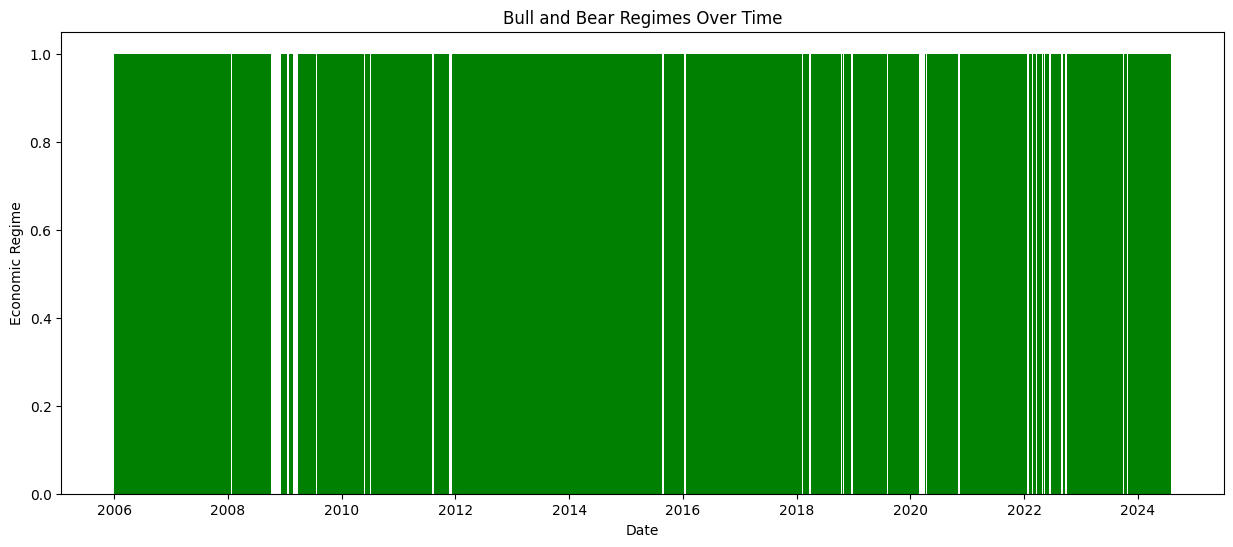

In [82]:
# Visualizing Smoothed Bull and Bear Regimes with a Bar Chart

# Step 1: Clean the data
# Remove rows with NaN values from the filtered prices DataFrame
cleaned_data = filtered_prices.dropna()

# Step 2: Convert the index to datetime
# Ensure the index (representing 'Date') is in datetime format, coercing errors
cleaned_data.index = pd.to_datetime(cleaned_data.index, errors='coerce')

# Step 3: Filter for valid regimes
# Keep only rows where 'Predicted_States' are Bull (1) or Bear (0) regimes
cleaned_data = cleaned_data[cleaned_data['Predicted_States'].isin([0, 1])]

# Step 4: Smooth the regime data
# Assign the cleaned data to a new DataFrame for further manipulation
smoothed_regime_data = cleaned_data

# Convert the index to datetime (important for smoothing operations later)
smoothed_regime_data.index = pd.to_datetime(smoothed_regime_data.index)

# Step 5: Extract regime states
# Ensure the 'Predicted_States' column contains only the Bull (1) and Bear (0) states
states = smoothed_regime_data['Predicted_States']

# Step 6: Map regimes to colors
# Define a color map for visualizing the regimes: Bull as green, Bear as red
colors = states.map({1: 'green', 0: 'red'})

# Step 7: Create the bar plot
# Initialize a figure and axis with a wide layout for better spacing
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the bar chart using the 'Date' index and the 'Predicted_States' values
ax.bar(smoothed_regime_data.index, states, color=colors, width=5, align='center')

# Step 8: Add labels and title
# Label the y-axis, x-axis, and give the plot a title
ax.set_ylabel('Economic Regime')
ax.set_xlabel('Date')
ax.set_title('Bull and Bear Regimes Over Time')

# Step 9: Display the plot
plt.show()


### Portfolio Construction Based on Market Regimes (Bull and Bear)

In [83]:
# Step 1: Convert 'month' column in the EPS dataset to proper month-end dates
# Align all 'month' values in the dataset to the last day of their respective month
data['month'] = pd.to_datetime(data['month']) + pd.offsets.MonthEnd(0)

# Step 2: Convert the daily index of smoothed_regime_data to datetime and resample to monthly
# Convert the index of `smoothed_regime_data` to datetime format
smoothed_regime_data.index = pd.to_datetime(smoothed_regime_data.index)

# Resample data to monthly frequency, taking the last daily observation for each month
smoothed_regime_data_monthly = (
    smoothed_regime_data[['Predicted_States']]
    .resample('M')  # Resample to monthly frequency
    .last()         # Use the last observation in each month
    .ffill()        # Forward fill missing months to ensure completeness
)

# Step 3: Align months and indices to be timezone-naive
# Prepare a unique list of month-end dates from the EPS dataset
# Ensure the resulting `months` index and regime data index are tz-naive
months = data['month'].drop_duplicates().sort_values()
months = pd.DatetimeIndex(months).tz_localize(None)

smoothed_regime_data_monthly.index = pd.DatetimeIndex(
    smoothed_regime_data_monthly.index
).tz_localize(None)

# Step 4: Initialize the position DataFrame and current holdings tracker
# Create a DataFrame to track portfolio positions for all stocks over all months
all_permnos = data['permno'].unique()  # Unique stock identifiers
position_df = pd.DataFrame(index=months, columns=all_permnos).fillna(0)

# Create a tracker for current stock holdings and their entry months
current_holdings = pd.DataFrame(columns=['permno', 'entry_month'])

# Step 5: Construct the portfolio month by month
# Iterate over each month and determine the economic regime to construct the portfolio
for i, current_month in enumerate(months):
    # Determine the economic regime for the current month (Bull: 1, Bear: 0)
    regime = smoothed_regime_data_monthly['Predicted_States'].asof(current_month)

    # Remove stocks that completed their 2-month holding period
    two_months_ago = current_month - pd.offsets.MonthEnd(2)
    holdings_to_remove = current_holdings[current_holdings['entry_month'] == two_months_ago]
    current_holdings = current_holdings[~current_holdings['permno'].isin(holdings_to_remove['permno'])]

    # Count currently held stocks and determine the number of new stocks to add
    current_holdings_count = len(current_holdings)

    # Determine the maximum number of new stocks to add based on the current month
    if i == 0:
        max_new_stocks_allowed = 50  # Initial portfolio size
    else:
        max_new_stocks_allowed = 25  # Monthly adjustment size

    num_new_stocks = max(50 - current_holdings_count, max_new_stocks_allowed)
    max_additional_stocks = 100 - current_holdings_count  # Portfolio size limit
    num_new_stocks = min(num_new_stocks, max_additional_stocks)

    if num_new_stocks > 0:
        # Filter data for the current month, excluding already-held stocks
        month_data = data[data['month'] == current_month]
        month_data = month_data[~month_data['permno'].isin(current_holdings['permno'])]

        # Skip stock selection if the regime is undefined
        if pd.isna(regime):
            regime = None

        # Select stocks based on the regime
        if regime == 1:  # Bull Market: Momentum strategy
            positive_mom_stocks = month_data[month_data['ret_12_1'] > 0]

            if len(positive_mom_stocks) >= 2 * num_new_stocks:
                selected_stocks_sub = positive_mom_stocks.nlargest(2 * num_new_stocks, 'ret_12_1')
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
            else:
                selected_stocks_sub = positive_mom_stocks
                num_needed = num_new_stocks - len(selected_stocks_sub)
                remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks_sub['permno'])]
                top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
                selected_stocks_sub = pd.concat([selected_stocks_sub, top_estimate_stocks])
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')

        elif regime == 0:  # Bear Market: ROE strategy
            positive_roe_stocks = month_data[month_data['ni_be'] > 0]

            if len(positive_roe_stocks) >= 2 * num_new_stocks:
                selected_stocks_sub = positive_roe_stocks.nlargest(2 * num_new_stocks, 'ni_be')
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
            else:
                selected_stocks_sub = positive_roe_stocks
                num_needed = num_new_stocks - len(selected_stocks_sub)
                remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks_sub['permno'])]
                top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
                selected_stocks_sub = pd.concat([selected_stocks_sub, top_estimate_stocks])
                selected_stocks = selected_stocks_sub.nlargest(num_new_stocks, 'diff')
        else:
            selected_stocks = pd.DataFrame()

        # Add selected stocks to the current holdings tracker
        if not selected_stocks.empty:
            new_holdings = pd.DataFrame({
                'permno': selected_stocks['permno'],
                'entry_month': current_month
            })
            current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)

    # Step 6: Update the portfolio holdings for the current month
    # Mark the selected stocks as held in the position DataFrame
    position_df.loc[current_month, current_holdings['permno']] = 1

# Step 7: Finalize the portfolio DataFrame
# Replace NaN values with 0 to indicate stocks not held
position_df = position_df.fillna(0)

# Add a column to track the total number of stocks held each month
position_df['num_stocks'] = position_df.sum(axis=1)



In [84]:
# Check if < 50
position_df[position_df['num_stocks'] < 50]

,81912,80303,84584,80361,80266,80191,80286,80204,76697,80079,...,86822,92601,75860,50606,21415,18835,21895,23439,15909,num_stocks
month,,,,,,,,,,,,,,,,,,,,,


In [85]:
# Check if > 100
position_df[position_df['num_stocks'] > 100]

,81912,80303,84584,80361,80266,80191,80286,80204,76697,80079,...,86822,92601,75860,50606,21415,18835,21895,23439,15909,num_stocks
month,,,,,,,,,,,,,,,,,,,,,


In [86]:
# Top 10 holdings
position_df.sum().sort_values(ascending=False).head(11)

num_stocks    8425
57665           54
80320           54
12448           52
61621           50
17144           50
29946           50
65307           48
81655           48
11618           46
93096           46
dtype: int64

### Calculating Portfolio Performance: Equal-Weighted Returns and Cumulative Returns


In [87]:
# Calculating Portfolio Performance: Equal-Weighted Returns and Cumulative Returns

# Step 1: Reshape the position DataFrame
# Melt the position DataFrame to transform it into a long format, where each row represents
# one stock position per month
position_melted = position_df.reset_index().melt(
    id_vars=['month'], var_name="permno", value_name="position"
)

# Step 2: Filter for held positions
# Keep only rows where the 'position' value is 1 (indicating the stock is held in the portfolio)
position_melted = position_melted[position_melted["position"] == 1]

# Step 3: Convert permno to integer
# Ensure the 'permno' column is of integer type to enable proper merging with other datasets
position_melted['permno'] = position_melted['permno'].astype(int)

# Step 4: Merge position data with excess return data
# Combine the melted position data with the individual stock excess return data (er_df)
# using 'month' and 'permno' as keys
merged_df = pd.merge(
    position_melted, er_df, left_on=['month', 'permno'], right_on=['date', 'permno']
)

# Step 5: Calculate equal-weighted portfolio return
# Group the merged data by month and compute the average excess return for all stocks held
portfolio_return = merged_df.groupby('month')['stock_exret'].mean().reset_index(name='equal_weighted_return')

# Step 6: Calculate cumulative return
# Compute the cumulative return of the portfolio by compounding monthly equal-weighted returns
portfolio_return['cumulative_return'] = (1 + portfolio_return['equal_weighted_return']).cumprod()

# Step 7: Rebase cumulative return to start at 100
# Normalize the cumulative return so that it starts at 100 in the first month
portfolio_return['cumulative_return'] = (
    portfolio_return['cumulative_return'] / portfolio_return['cumulative_return'].iloc[0] * 100
)

# Display the resulting portfolio performance DataFrame
portfolio_return


,month,equal_weighted_return,cumulative_return
0,2010-01-31,-0.045117,100.000000
1,2010-02-28,0.059209,105.920854
2,2010-03-31,0.072763,113.627959
3,2010-04-30,0.052625,119.607663
4,2010-05-31,-0.082868,109.696070
...,...,...,...
163,2023-08-31,-0.033653,493.143764
164,2023-09-30,-0.073614,456.841260
165,2023-10-31,-0.055917,431.296206
166,2023-11-30,0.097616,473.397611


## Performance Comparison

#### Loading and Preparing the S&P 500 Dataset as a Benchmark

In [88]:
# Loading and Preparing the S&P 500 Dataset as a Benchmark

# Step 1: Download the S&P 500 historical data
# Fetch daily historical data for the S&P 500 index from Yahoo Finance
sp500_df = yf.download('^SPX', start='2009-01-01', end='2024-02-02')

# Step 2: Select the closing price
# Keep only the 'Close' column from the downloaded data for return calculations
sp500_df = sp500_df[['Close']]

# Step 3: Resample data to monthly frequency
# Aggregate the daily data into monthly data by taking the last observation of each month
sp500_monthly = sp500_df.resample('M').last()

# Step 4: Calculate monthly returns
# Compute the percentage change in closing prices to get monthly returns
sp500_monthly['monthly_return'] = sp500_monthly['Close'].pct_change()

# Step 5: Drop rows with NaN values
# Remove rows with missing values resulting from the percentage change calculation
sp500_monthly = sp500_monthly.dropna()

# Step 6: Reset the index and reformat dates
# Convert the index to datetime format and reset it to make 'Date' a column
sp500_monthly = sp500_monthly.reset_index()
sp500_monthly['Date'] = sp500_monthly['Date'].dt.date  # Convert datetime to plain date format
sp500_monthly = sp500_monthly.set_index('Date')  # Set 'Date' as the index again

# Step 7: Handle MultiIndex columns (if applicable)
# If the columns are a MultiIndex, flatten them to a single-level index
if isinstance(sp500_monthly.columns, pd.MultiIndex):
    sp500_monthly.columns = sp500_monthly.columns.get_level_values(0)

# Step 8: Display the cleaned DataFrame
# Print the final S&P 500 monthly data for verification
print(sp500_monthly)


[*********************100%***********************]  1 of 1 completed

Price             Close  monthly_return
Date                                   
2009-02-28   735.090027       -0.109931
2009-03-31   797.869995        0.085404
2009-04-30   872.809998        0.093925
2009-05-31   919.140015        0.053081
2009-06-30   919.320007        0.000196
...                 ...             ...
2023-10-31  4193.799805       -0.021980
2023-11-30  4567.799805        0.089179
2023-12-31  4769.830078        0.044229
2024-01-31  4845.649902        0.015896
2024-02-29  4906.189941        0.012494

[181 rows x 2 columns]


### Merging Portfolio and S&P 500 Data for Benchmark Comparison and Excess Return Analysis

In [89]:
# Step 1: Reset the S&P 500 monthly DataFrame index
# Convert the index ('Date') of `sp500_monthly` to a column for easier merging
sp_monthly_reset = sp500_monthly.reset_index()

# Ensure the 'Date' column is of datetime format for consistency during merging
sp_monthly_reset['Date'] = pd.to_datetime(sp_monthly_reset['Date'])

# Step 2: Convert the 'month' column in the portfolio DataFrame to datetime
# Ensure the 'month' column in the portfolio return DataFrame is in datetime format
portfolio_return['month'] = pd.to_datetime(portfolio_return['month'])

# Step 3: Merge portfolio and S&P 500 data
# Merge the portfolio returns with S&P 500 monthly returns using the 'month' and 'Date' columns
# Perform a left join to keep all portfolio months and match S&P data where available
merged_df = pd.merge(
    portfolio_return, 
    sp_monthly_reset[['Date', 'monthly_return']],  # Include only necessary columns from S&P data
    left_on='month', 
    right_on='Date', 
    how='left'
)

# Step 4: Drop rows without S&P 500 monthly returns
# Remove rows where S&P 500 monthly returns are missing
merged_df = merged_df.dropna(subset=['monthly_return'])

# Step 5: Prepare unique dates DataFrame for risk-free rates
# Extract unique dates from `er_df` and filter them within the desired date range
df_unique_dates = er_df.drop_duplicates(subset='date', keep='first').reset_index(drop=True)
df_unique_dates = df_unique_dates[
    df_unique_dates['date'].between('2010-01-31', '2023-12-31')
].reset_index(drop=True)

# Step 6: Calculate monthly excess return
# Subtract the risk-free rate from the S&P 500 monthly returns to compute excess returns
merged_df['monthly_excess_return'] = merged_df['monthly_return'] - df_unique_dates['rf']

# Step 7: Calculate cumulative return for S&P 500
# Compute the cumulative return by compounding monthly excess returns
merged_df['sp500_cumulative_return'] = (1 + merged_df['monthly_excess_return']).cumprod()

# Rebase the cumulative return to start at 100 for better comparability
merged_df['sp500_cumulative_return'] = (
    merged_df['sp500_cumulative_return'] 
    / merged_df['sp500_cumulative_return'].iloc[0] 
    * 100
)

# Step 8: Display the head of the merged DataFrame
# Print the first few rows of the merged DataFrame to verify the calculations
merged_df.head()


,month,equal_weighted_return,cumulative_return,Date,monthly_return,monthly_excess_return,sp500_cumulative_return
0,2010-01-31,-0.045117,100.000000,2010-01-31,-0.036974,-0.036974,100.000000
1,2010-02-28,0.059209,105.920854,2010-02-28,0.028514,0.028514,102.851369
2,2010-03-31,0.072763,113.627959,2010-03-31,0.058796,0.058696,108.888377
3,2010-04-30,0.052625,119.607663,2010-04-30,0.014759,0.014659,110.484596
4,2010-05-31,-0.082868,109.696070,2010-05-31,-0.081976,-0.082076,101.416480


#### Evaluation of EPS Surprise Enhanced Momentum Strategy Performance

In [90]:
# Step 1: Calculate the Sharpe Ratio
# Sharpe ratio measures risk-adjusted return; it is annualized by multiplying by sqrt(12)
sharpe = (
    merged_df["equal_weighted_return"].mean() / merged_df["equal_weighted_return"].std() * np.sqrt(12)
)
print("Sharpe Ratio:", sharpe)

# Step 2: Perform Newey-West Regression
# Use Newey-West regression for robust standard errors to account for heteroskedasticity and autocorrelation
nw_ols = smf.ols(
    formula="equal_weighted_return ~ monthly_excess_return", 
    data=merged_df[['equal_weighted_return', 'monthly_excess_return']]
).fit(cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True)

# Extract and print alpha, t-statistic, and information ratio
print("CAPM Annualized Alpha:", nw_ols.params["Intercept"] * 12)  # Annualized alpha
print("t-statistic:", nw_ols.tvalues["Intercept"])  # t-statistic for alpha
print(
    "Information Ratio:", 
    nw_ols.params["Intercept"] / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)  # Information ratio
)

# Step 3: Calculate Max 1-Month Loss
# Find the minimum monthly return to identify the maximum single-month loss
max_1m_loss = merged_df["equal_weighted_return"].min()
print("Max 1-Month Loss:", max_1m_loss)

# Step 4: Calculate Maximum Drawdown
# Calculate cumulative returns and identify the largest peak-to-trough drop
merged_df["log_port_11"] = np.log(merged_df["equal_weighted_return"] + 1)  # Log returns
merged_df["cumsum_log_port_11"] = merged_df["log_port_11"].cumsum(axis=0)  # Cumulative log returns
rolling_peak = merged_df["cumsum_log_port_11"].cummax()  # Rolling peak of cumulative returns
drawdowns = rolling_peak - merged_df["cumsum_log_port_11"]  # Difference between peak and current
max_drawdown = drawdowns.max()  # Maximum drawdown
print("Maximum Drawdown:", max_drawdown)

# Step 5: Calculate Annualized Excess Returns and Standard Deviation
# Compute the annualized return and volatility for both the portfolio and benchmark
mean_monthly_return = merged_df[['equal_weighted_return', 'monthly_excess_return']].mean()
monthly_std_dev = merged_df[['equal_weighted_return', 'monthly_excess_return']].std()
annualized_return = (1 + mean_monthly_return)**12 - 1  # Annualized return
annualized_std_dev = monthly_std_dev * np.sqrt(12)  # Annualized volatility

print('Annualized Return (Portfolio):', annualized_return[0])
print('Benchmark Annualized Return (S&P 500):', annualized_return[1])
print('Annualized Std Dev (Portfolio):', annualized_std_dev[0])
print('Benchmark Annualized Std Dev (S&P 500):', annualized_std_dev[1])

# Step 6: Calculate Annual Turnover
# Turnover measures portfolio rebalancing frequency by calculating traded volume
temp_df = position_df.reset_index()
temp_df['month'] = pd.to_datetime(temp_df['month'])
temp_df['year'] = temp_df['month'].dt.year

# Calculate absolute changes in position to estimate rebalancing
position_changes = temp_df.drop(columns=['num_stocks', 'month', 'year']).diff().abs()
position_changes['year'] = temp_df['year']

# Sum traded volume and average portfolio size per year
annual_traded_volume = position_changes.groupby('year').sum().sum(axis=1)
average_portfolio_size = temp_df.groupby('year')['num_stocks'].mean()

# Compute annual turnover as a percentage
annual_turnover = (annual_traded_volume * 100 / (2 * average_portfolio_size)).reset_index()
annual_turnover.columns = ['year', 'annual_turnover_%']

# Print average annual turnover
print('Annual Turnover (%):', annual_turnover['annual_turnover_%'].mean())


Sharpe Ratio: 0.7261714972729153
CAPM Annualized Alpha: 0.015355165417442494
t-statistic: 0.6831286735883263
Information Ratio: 0.18738711532267843
Max 1-Month Loss: -0.19960469013600002
Maximum Drawdown: 0.33204626887632593
Annualized Return (Portfolio): 0.13800998263514552
Benchmark Annualized Return (S&P 500): 0.11210279850023297
Annualized Std Dev (Portfolio): 0.17899355188689306
Benchmark Annualized Std Dev (S&P 500): 0.14828432716400913
Annual Turnover (%): 580.6171428571428


#### Enhanced Portfolio Construction, Performance Evaluation, and Benchmark Comparison

In [91]:
# Step 1: Sort and extract unique months and permnos
# Extract unique months from the 'data' DataFrame and sort them
months = data['month'].drop_duplicates().sort_values()

# Extract all unique stock identifiers (permnos) from the 'data' DataFrame
all_permnos = data['permno'].unique()

# Step 2: Initialize the position DataFrame
# Create a DataFrame to track stock positions for each month and stock
# Initialize all positions to zero
position_df_compare = pd.DataFrame(index=months, columns=all_permnos).fillna(0)

# Step 3: Initialize a tracker for 2-month holding periods
# Create a DataFrame to track stocks currently held and their entry months
current_holdings = pd.DataFrame(columns=['permno', 'entry_month'])

# Step 4: Loop through each month to construct the portfolio
for i, current_month in enumerate(months):
    # Step 4.1: Remove stocks that completed their 2-month holding period
    # Identify stocks that were added 2 months ago and remove them from holdings
    two_months_ago = current_month - pd.offsets.MonthEnd(2)
    holdings_to_remove = current_holdings[current_holdings['entry_month'] == two_months_ago]
    current_holdings = current_holdings[~current_holdings['permno'].isin(holdings_to_remove['permno'])]

    # Step 4.2: Calculate the current number of stocks held
    current_holdings_count = len(current_holdings)

    # Step 4.3: Determine the number of new stocks to add
    if i == 0:
        # For the initial portfolio, allow up to 50 new stocks
        max_new_stocks_allowed = 50
    else:
        # For subsequent months, allow up to 25 new stocks
        max_new_stocks_allowed = 25

    # Ensure the total holdings remain between 50 and 100
    num_new_stocks = max(max(50 - current_holdings_count, 0), max_new_stocks_allowed)
    max_additional_stocks = 100 - current_holdings_count
    num_new_stocks = min(num_new_stocks, max_additional_stocks)

    # Step 4.4: Select new stocks to add to the portfolio
    if num_new_stocks > 0:
        # Filter the data for the current month and exclude already-held stocks
        month_data = data[data['month'] == current_month]
        month_data = month_data[~month_data['permno'].isin(current_holdings['permno'])]

        # Select stocks with positive 'ret_12_1' (momentum signal)
        positive_mom_stocks = month_data[month_data['ret_12_1'] > 0]

        if len(positive_mom_stocks) >= num_new_stocks:
            # Select the top 'num_new_stocks' based on 'ret_12_1'
            selected_stocks = positive_mom_stocks.nlargest(num_new_stocks, 'ret_12_1')
        else:
            # Use all stocks with positive momentum and fill the remainder based on 'diff'
            selected_stocks = positive_mom_stocks
            num_needed = num_new_stocks - len(selected_stocks)
            remaining_stocks = month_data[~month_data['permno'].isin(selected_stocks['permno'])]
            top_estimate_stocks = remaining_stocks.nlargest(num_needed, 'diff')
            selected_stocks = pd.concat([selected_stocks, top_estimate_stocks])

        # Add the selected stocks to the current holdings tracker
        new_holdings = pd.DataFrame({'permno': selected_stocks['permno'], 'entry_month': current_month})
        current_holdings = pd.concat([current_holdings, new_holdings], ignore_index=True)

    # Step 4.5: Update the position DataFrame
    # Mark the selected stocks as held in the portfolio for the current month
    position_df_compare.loc[current_month, current_holdings['permno']] = 1

# Step 5: Finalize the position DataFrame
# Replace NaN values with 0 and add a column to track the number of stocks held each month
position_df_compare = position_df_compare.fillna(0)
position_df_compare['num_stocks'] = position_df_compare.sum(axis=1)

# Step 6: Reshape the position DataFrame for analysis
# Reset the index to turn 'month' into a column and melt the DataFrame
temp_df = position_df_compare.reset_index()
temp_df.rename(columns={'index': 'month'}, inplace=True)

# Convert the wide format DataFrame into a long format with one row per stock per month
position_melted_compare = temp_df.melt(
    id_vars=['month'],        # Keep 'month' as a separate column
    var_name="permno", 
    value_name="position"
)

# Filter the melted DataFrame to include only rows where position == 1
position_melted_compare = position_melted_compare[position_melted_compare["position"] == 1]

# Ensure the 'permno' column is of integer type
position_melted_compare['permno'] = position_melted_compare['permno'].astype(int)

# Step 7: Merge the portfolio data with excess return data
# Merge the melted position data with the excess return data (er_df) based on 'month' and 'permno'
merged_df_compare = pd.merge(
    position_melted_compare, 
    er_df, 
    left_on=['month', 'permno'], 
    right_on=['date', 'permno']
)

# Step 8: Calculate portfolio returns and cumulative returns
# Group by 'month' and calculate the mean stock excess return to get the equal-weighted portfolio return
portfolio_return_compare = (
    merged_df_compare
    .groupby('month')['stock_exret']
    .mean()
    .reset_index(name='equal_weighted_return')
)

# Compute cumulative returns rebased to start at 100
portfolio_return_compare['cumulative_return'] = (1 + portfolio_return_compare['equal_weighted_return']).cumprod()
portfolio_return_compare['cumulative_return'] = (
    portfolio_return_compare['cumulative_return'] 
    / portfolio_return_compare['cumulative_return'].iloc[0] 
    * 100
)

# Step 9: Merge the portfolio data with S&P 500 monthly returns
# Reset the index of the S&P 500 data if it is a DatetimeIndex
sp_monthly_reset = sp500_monthly.reset_index()
sp_monthly_reset['Date'] = pd.to_datetime(sp_monthly_reset['Date'])

# Ensure the 'month' column in the portfolio return DataFrame is in datetime format
portfolio_return_compare['month'] = pd.to_datetime(portfolio_return_compare['month'])

# Merge portfolio returns with S&P 500 monthly returns based on 'month' and 'Date'
merged_df_compare = pd.merge(
    portfolio_return_compare, 
    sp_monthly_reset[['Date', 'monthly_return']], 
    left_on='month', 
    right_on='Date',
    how='left'
)

# Drop rows where S&P 500 monthly returns are missing
merged_df_compare = merged_df_compare.dropna(subset=['monthly_return'])

# Step 10: Calculate monthly excess returns and cumulative returns
# Compute monthly excess returns by subtracting the risk-free rate (rf) from S&P 500 monthly returns
df_unique_dates = er_df.drop_duplicates(subset='date', keep='first').reset_index(drop=True)
df_unique_dates = df_unique_dates[df_unique_dates['date'].between('2010-01-31', '2023-12-31')].reset_index(drop=True)

merged_df_compare['monthly_excess_return'] = (
    merged_df_compare['monthly_return'] - df_unique_dates['rf']
)

# Compute cumulative excess returns rebased to start at 100
merged_df_compare['sp500_cumulative_return'] = (1 + merged_df_compare['monthly_excess_return']).cumprod()
merged_df_compare['sp500_cumulative_return'] = (
    merged_df_compare['sp500_cumulative_return']
    / merged_df_compare['sp500_cumulative_return'].iloc[0]
    * 100
)

# Step 11: Evaluate portfolio performance metrics
# Calculate Sharpe ratio (annualized)
sharpe = (
    merged_df_compare["equal_weighted_return"].mean() 
    / merged_df_compare["equal_weighted_return"].std()
    * np.sqrt(12)
)
print("Sharpe Ratio:", sharpe)

# Perform Newey-West regression to estimate CAPM alpha and other metrics
nw_ols = smf.ols(
    formula="equal_weighted_return ~ monthly_excess_return",
    data=merged_df_compare[['equal_weighted_return', 'monthly_excess_return']]
).fit(cov_type="HAC", cov_kwds={"maxlags": 3}, use_t=True)

print("CAPM Annualized Alpha:", nw_ols.params["Intercept"] * 12)
print("t-statistic:", nw_ols.tvalues["Intercept"])
info_ratio = nw_ols.params["Intercept"] / np.sqrt(nw_ols.mse_resid) * np.sqrt(12)
print("Information Ratio:", info_ratio)

# Calculate maximum 1-month loss
max_1m_loss = merged_df_compare["equal_weighted_return"].min()
print("Max 1-Month Loss:", max_1m_loss)

# Calculate maximum drawdown
merged_df_compare["log_port_11"] = np.log(1 + merged_df_compare["equal_weighted_return"])
merged_df_compare["cumsum_log_port_11"] = merged_df_compare["log_port_11"].cumsum()
rolling_peak = merged_df_compare["cumsum_log_port_11"].cummax()
drawdowns = rolling_peak - merged_df_compare["cumsum_log_port_11"]
max_drawdown = drawdowns.max()
print("Maximum Drawdown:", max_drawdown)

# Step 12: Compute annualized returns and standard deviations
# Calculate annualized returns for the portfolio and benchmark
mean_monthly_return = merged_df_compare[['equal_weighted_return', 'monthly_excess_return']].mean()
annualized_return = (1 + mean_monthly_return)**12 - 1
print('Annualized Return (portfolio):', annualized_return[0])

# Calculate annualized standard deviations
monthly_std_dev = merged_df_compare[['equal_weighted_return', 'monthly_excess_return']].std()
annualized_std_dev = monthly_std_dev * np.sqrt(12)
print('Annualized std_dev (portfolio):', annualized_std_dev[0])

# Step 13: Calculate portfolio turnover
# Compute turnover by calculating changes in positions year-over-year
temp_df = position_df_compare.reset_index()
temp_df.rename(columns={'index': 'month'}, inplace=True)
temp_df['month'] = pd.to_datetime(temp_df['month'])
temp_df['year'] = temp_df['month'].dt.year

# Calculate absolute changes in positions and aggregate annually
position_changes = temp_df.drop(columns=['num_stocks', 'month', 'year']).diff().abs()
position_changes['year'] = temp_df['year']

annual_traded_volume = position_changes.groupby('year').sum().sum(axis=1)
average_portfolio_size = temp_df.groupby('year')['num_stocks'].mean()

# Calculate annual turnover as a percentage
annual_turnover = (annual_traded_volume * 100 / (2 * average_portfolio_size)).reset_index()
annual_turnover.columns = ['year', 'annual_turnover_%']
print('Annual Turnover (%):', annual_turnover['annual_turnover_%'].mean())



Sharpe Ratio: 0.6371443148762437
CAPM Annualized Alpha: 0.0038080306630837593
t-statistic: 0.1415571043278507
Information Ratio: 0.03774970363115515
Max 1-Month Loss: -0.20340807158000002
Maximum Drawdown: 0.3511291002644398
Annualized Return (portfolio): 0.13225724422418828
Annualized std_dev (portfolio): 0.19596548871990535
Annual Turnover (%): 570.0571428571428


### Visualizing Portfolio Performance Against S&P 500 Cumulative Returns

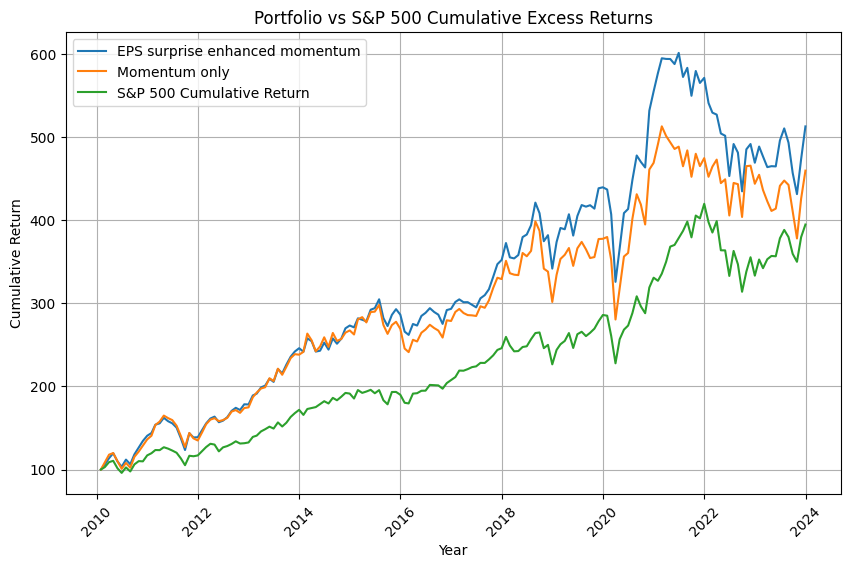

In [92]:
# Visualizing Portfolio Performance Against S&P 500 Cumulative Returns

# Step 1: Initialize the figure
# Set the figure size to ensure the plot is clear and readable
plt.figure(figsize=(10, 6))

# Step 2: Plot cumulative returns for EPS surprise enhanced momentum strategy
# Use 'month' as the x-axis and 'cumulative_return' as the y-axis
plt.plot(
    merged_df['month'], 
    merged_df['cumulative_return'], 
    linestyle='-', 
    label='EPS surprise enhanced momentum'
)

# Step 3: Plot cumulative returns for the momentum-only strategy
# Use 'month' and 'cumulative_return' from the portfolio_return_compare DataFrame
plt.plot(
    portfolio_return_compare['month'], 
    portfolio_return_compare['cumulative_return'], 
    linestyle='-', 
    label='Momentum only'
)

# Step 4: Plot cumulative returns for the S&P 500 benchmark
# Use 'month' and 'sp500_cumulative_return' as x and y axes
plt.plot(
    merged_df['month'], 
    merged_df['sp500_cumulative_return'], 
    linestyle='-', 
    label='S&P 500 Cumulative Return'
)

# Step 5: Add title, labels, and formatting
# Add a title to indicate the purpose of the chart
plt.title('Portfolio vs S&P 500 Cumulative Excess Returns')

# Label the x-axis as 'Year' and the y-axis as 'Cumulative Return'
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid lines for better readability of data points
plt.grid(True)

# Step 6: Add legend to distinguish between the plotted lines
plt.legend()

# Step 7: Display the plot
# Show the figure
plt.show()
